In [43]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i/3dsbdd
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i


Reading data from crossdock dataset, add a standardization for small molecule data:

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i/3dsbdd/500_generated.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/489 [00:00<?, ?mol/s]

[15:08:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:08:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:08:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:08:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:08:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 15 17 18 20
[15:08:18] Explicit valence for atom # 17 N, 4, is greater than permitted


Skipping molecule OC1CCCCN12CC2C1(c2ccccc2)C=C1
Skipping molecule O=C1CCN2CC2N12CC2C1(c2ccccc2)C=C1
Skipping molecule OC1CCN2CC2N12CC2C1(c2ccccc2)C=C1
Skipping molecule NC1CCC(=O)N2(C1)CC2C1(c2ccccc2)C=C1
Skipping molecule Cc1ccc2c(C3(c4ccccc4)C=C3)c([nH])-nc(C)c-2o1
Skipping molecule CC1C2C3NN=C(C4(c5ccc(O)cc5)C=C4)N32CCN1C


[15:08:21] Explicit valence for atom # 10 N, 4, is greater than permitted


Skipping molecule O=C1N2C(CNC3=NC(=O)N45CC4CCC35)C2OC2CC12C1CCCC(C2C3C4CC5(C6(c7ccccc7)CC6)C2C5C43)C1


[15:08:25] Explicit valence for atom # 51 N, 4, is greater than permitted


Skipping molecule C(=CC1OC1CC=CC12CCCC(CC=CCCCc3ccc4c(c3)C3C(CC4)C34COc3ccccc3C43CC3)C1C2)CCCCC1CCCN23CC12c1ccccc1N3


[15:08:25] Explicit valence for atom # 60 N, 4, is greater than permitted


Skipping molecule NC1N2C3OC3CC(CCCCC=CC3OC3CC=CC34CCCC(CC=CCCCc5ccc6c(c5)C5C(CC6)C56CC5OC57CC=CC=C7C65CC5)C3C4)C2C2C3C2N31C=O


[15:08:26] Explicit valence for atom # 66 N, 4, is greater than permitted


Skipping molecule NC1N2COCCC(CCCCC=CC3OC3CC3CC3C34CCCC(CC=CCCCc5ccc6c(c5)C5C(CC6)C56CC5OC57CC=CC=C7C65CC5)C3C4)C23C2=C4C5(CN5C5CO5)N41C14OC1C234
489


479

Set the default image size

In [5]:
with open('500_generated_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CCNCC
1,CC=CCCC
2,CCC=CCC
3,CCN1CCCC1
4,N=c1cccc[nH]1
...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...


Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,CCNCC
1,CC=CCCC
2,CCC=CCC
3,CCN1CCCC1
4,N=c1cccc[nH]1
...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...


Save the smi file for further use

Add an RDKit molecule to the dataframe

In [10]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

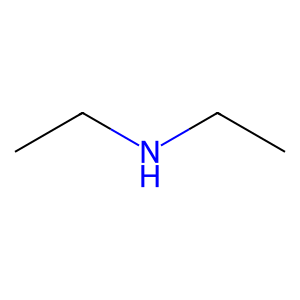

In [11]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [12]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                                                     []
1                                                     []
2                                                     []
3                                              [C1CCNC1]
4                                        [N=c1cccc[nH]1]
                             ...                        
474    [C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...
475    [O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...
476    [O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...
477    [C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...
478    [c1ccccc1, C1CC1, c1ccc2c(c1)C1C3C1C1C2C12OC32...
Name: ring_sytems, Length: 479, dtype: object

In [13]:
df.ring_sytems.values

array([list([]), list([]), list([]), list(['C1CCNC1']),
       list(['N=c1cccc[nH]1']), list(['C1CCNC1']), list(['C1CCN2CC2C1']),
       list(['O=C1CN1', 'C1CCNC1']),
       list(['C1CCNCC1', 'C1=CC1', 'c1ccccc1']),
       list(['C1=NNC2CC2=C1', 'C1=CC1', 'c1ccccc1']),
       list(['C1CN1', 'C1=CC1', 'c1ccccc1']),
       list(['C1=CCNN=C1', 'C1=CC1', 'c1ccccc1']),
       list(['C1CCC2NC2C1', 'C1=CC1', 'c1ccccc1']),
       list(['C1=NNC=C2C=NC3CC3C12', 'c1ccccc1']),
       list(['C1CN1', 'C1CC1', 'c1ccccc1', 'C1CN1']),
       list(['c1ccccc1', 'C1C2C3OC3CC3(CC3)C12', 'C1CC1']),
       list(['C1CC1', 'C1CC1', 'C1CC1', 'c1ccccc1']),
       list(['N=c1cccc[nH]1', 'C1=CC1', 'c1ccccc1']),
       list(['C1=CCC2NC2C1', 'c1ccc2c(c1)N=C1NC1C21CC1']),
       list(['C1CCNCC1', 'C1=CC1', 'c1ccccc1']),
       list(['C1C2NC2OC2C1OC1OC12', 'C1=CC1', 'c1ccccc1']),
       list(['C1=NCCC2CCC3=C(C12)C1(CC1)c1ccccc1O3']),
       list(['C1=NCCC2CCC3Oc4ccccc4C4(CC4)C3C12']),
       list(['O=C1NC2CNCCC2C2CCCC

See how many times each ring system occurs

In [14]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
23,C1=CCC23OC2CC2(C4CCc5ccccc5C42)C2(CC2)C3=C1,154
12,C1CC1,118
77,C1CO1,112
49,C1CCC2CC2C1,110
27,C1CCCCC1,99
...,...,...
130,C1=NCC23NCCC12N3,1
131,C1COC2CC2N1,1
132,O=C1CCCC2CN12,1
133,N=C1C(=O)OC2CC12,1


View the ring system frequencies

In [15]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [16]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [17]:
res

0                                                     []
1                                                     []
2                                                     []
3                                    [(C1CCNC1, 136431)]
4                                 [(N=c1cccc[nH]1, 151)]
                             ...                        
474    [(C1C2NC2N2C3C4=NC4NC132, 0), (C1=NCNCC1, 16),...
475    [(O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C...
476    [(O=C1C=CC2CC23CCCCN13, 0), (C1=NCNCC1, 16), (...
477    [(C1C2NC2N2C3C4=NC4NC132, 0), (C1=NCNCC1, 16),...
478    [(c1ccccc1, 2568039), (C1CC1, 90040), (c1ccc2c...
Name: mol, Length: 479, dtype: object

In [18]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151
...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0


In [19]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [20]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefined stereo

[15:09:11] WARNING: Omitted undefi

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3"
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3"
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3"
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3"
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)"
...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...


How many of them have ring system?

In [21]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3"
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)"
5,CC1CNCC1CO,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c00>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13NO/c1-5-2-7-3-6(5)4-8/h5-8H,2-4H..."
6,OC1CCCN2CC12,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c70>,[C1CCN2CC2C1],C1CCN2CC2C1,0,"InChI=1S/C6H11NO/c8-6-2-1-3-7-4-5(6)7/h5-6,8H,..."
7,O=C1NC1CN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ce0>,"[O=C1CN1, C1CCNC1]",O=C1CN1,1,InChI=1S/C7H12N2O/c10-7-6(8-7)5-9-3-1-2-4-9/h6...
...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...


In [22]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3"
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)"
5,CC1CNCC1CO,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c00>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13NO/c1-5-2-7-3-6(5)4-8/h5-8H,2-4H..."
14,CC(CN1CC1C1(c2ccccc2)CC1N)N1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ff0>,"[C1CN1, C1CC1, c1ccccc1, C1CN1]",C1CN1,1557,InChI=1S/C16H23N3/c1-12(18-7-8-18)10-19-11-15(...
16,NC(O)C(C1CC1)C1(C2(c3ccccc3)CC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7b39854770d0>,"[C1CC1, C1CC1, C1CC1, c1ccccc1]",C1CC1,90040,InChI=1S/C17H23NO/c18-15(19)14(12-6-7-12)17(10...


### How many of them could pass PAINS filter?

Get a list of rules

In [23]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [24]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [25]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [26]:
reos.pandas_mols(df.mol)

  0%|          | 0/479 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
474,ok,ok
475,ok,ok
476,ok,ok
477,ok,ok


In [27]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/479 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",ok,ok
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",ok,ok
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",ok,ok
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",ok,ok
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",ok,ok
...,...,...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...,ok,ok
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...,ok,ok
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...,ok,ok
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...,ok,ok


Test all filters from rd filters

In [28]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/479 [00:00<?, ?it/s]

Glaxo 0.24634655532359082 ['Glaxo'] 118


  0%|          | 0/479 [00:00<?, ?it/s]

Dundee 0.04384133611691023 ['Dundee'] 21


  0%|          | 0/479 [00:00<?, ?it/s]

BMS 0.511482254697286 ['BMS'] 245


  0%|          | 0/479 [00:00<?, ?it/s]

SureChEMBL 0.1837160751565762 ['SureChEMBL'] 88


  0%|          | 0/479 [00:00<?, ?it/s]

MLSMR 0.06889352818371608 ['MLSMR'] 33


  0%|          | 0/479 [00:00<?, ?it/s]

Inpharmatica 0.24425887265135698 ['Inpharmatica'] 117


  0%|          | 0/479 [00:00<?, ?it/s]

LINT 0.21711899791231734 ['LINT'] 104


### How many of them could pass filters suggested by Dr.Reymond?

In [29]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",True
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",True
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",True
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True
...,...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...,False
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...,False
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...,False
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...,False


In [30]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",True
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",True
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",True
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True
...,...,...,...,...,...,...,...
468,Cc1nc2c3n1CCC=C=CC=CCCC1C(=NCC4C5C=CC(OC23)N2C...,<rdkit.Chem.rdchem.Mol object at 0x7b39854836f0>,[C1=CC=CCCC2CNCNC2=NCC2C3C=CC(OC4c5ncn(c54)CCC...,C1=CC=CCCC2CNCNC2=NCC2C3C=CC(OC4c5ncn(c54)CCC=...,0,InChI=1S/C77H97N7O4/c1-49-82-68-69-70(68)88-66...,True
469,CCC=CC=CCCC=C=CCCCC=CCCC1C=NCNC1NCC1C2=CCC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483760>,"[C1=NCNCC1, O=C1CC=C2CC23CCC2OC2N13, C1CO1, C1...",O=C1CC=C2CC23CCC2OC2N13,0,InChI=1S/C80H104N4O5/c1-2-3-4-5-6-7-8-9-10-11-...,True
470,NC1NCN=C(NCC2C3=CCC(=O)N4CCCC(CCCCC=CC5OC5CC5C...,<rdkit.Chem.rdchem.Mol object at 0x7b39854837d0>,"[C1=NCNCC1, O=C1CC=C2CC23CCCCN13, C1CO1, C1CCC...",O=C1CC=C2CC23CCCCN13,0,InChI=1S/C81H106N8O4/c82-74-63(31-19-10-8-6-4-...,True
471,NC1NCN=C(NC2C3C4C3(CC3OC3C=CCCCCC3CCCN5C(=O)C=...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483840>,"[C1=NCNCC1, O=C1C=CC2C3CC4C5C4(CC4OC4C=CCCCCC4...",O=C1C=CC2C3CC4C5C4(CC4OC4C=CCCCCC4CCCN1C423)OC...,0,InChI=1S/C81H102N8O4/c82-73-59(31-19-10-8-6-4-...,True


### How many of them could pass RO5?

In [31]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",True,True
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",True,True
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",True,True
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
...,...,...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...,False,False
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...,False,False
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...,False,False
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...,False,False


In [32]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",True,True
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",True,True
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",True,True
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136431,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,151,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
...,...,...,...,...,...,...,...,...
152,OC1C2C3CC(=C4C=C5C(CC4)CCC4C5C45CC4OC46CC=CC=C...,<rdkit.Chem.rdchem.Mol object at 0x7b398547ab90>,[C1=CCC23OC2CC2(C4CCC5CCC(=C6CC7OC8OC8CC6N6CC7...,C1=CCC23OC2CC2(C4CCC5CCC(=C6CC7OC8OC8CC6N6CC76...,0,InChI=1S/C31H35NO4/c33-27-26-21-12-17(20(32(26...,True,True
154,COC1CC2C(=C3C=C4C(CC3)CCC3C4C34CC3OC35CC=CC=C5...,<rdkit.Chem.rdchem.Mol object at 0x7b398547ac70>,[C1=CCC23OC2CC2(C4CCC5CCC(=C6CC7NCCC6N6CC76)C=...,C1=CCC23OC2CC2(C4CCC5CCC(=C6CC7NCCC6N6CC76)C=C...,0,InChI=1S/C31H38N2O3/c1-35-25-14-22-18(13-21(32...,True,True
156,OC1C2CCC3(C4CCC5CCC6C(C5CC43)C63CC4OC45CC=CC=C...,<rdkit.Chem.rdchem.Mol object at 0x7b398547ad50>,[C1=CCC23OC2CC2(C4CCC5CCC6C(CC5C42)C62CCC4CN4C...,C1=CCC23OC2CC2(C4CCC5CCC6C(CC5C42)C62CCC4CN4C2...,0,InChI=1S/C32H41NO3/c34-28-23-8-10-30(25(33(23)...,True,True
159,O=C1CC2(C3CCC4CCC5C(CC4C32)C52CCC3C(O)N3C2CC2C...,<rdkit.Chem.rdchem.Mol object at 0x7b398547aea0>,[O=C1CC2(C3CCC4CCC5C(CC4C32)C52CCC3CN3C2)C2(CC...,O=C1CC2(C3CCC4CCC5C(CC4C32)C52CCC3CN3C2)C2(CC2...,0,InChI=1S/C32H39NO3/c34-26-15-32(30(11-12-30)21...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [33]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0                                                     []
1                                                     []
2                                                     []
3                               [(C1CCNC1, 14763048450)]
4                           [(N=c1cccc[nH]1, 265100018)]
                             ...                        
474    [(C1C2NC2N2C3C4=NC4NC132, 0), (C1=NCNCC1, 22),...
475    [(O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C...
476    [(O=C1C=CC2CC23CCCCN13, 0), (C1=NCNCC1, 22), (...
477    [(C1C2NC2N2C3C4=NC4NC132, 0), (C1=NCNCC1, 22),...
478    [(c1ccccc1, 21243538754), (C1CC1, 17361841694)...
Name: mol, Length: 479, dtype: object

In [34]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",True,True
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",True,True
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",True,True
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,265100018,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
...,...,...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...,False,False
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...,False,False
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...,False,False
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...,False,False


In [35]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,265100018,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
5,CC1CNCC1CO,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c00>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13NO/c1-5-2-7-3-6(5)4-8/h5-8H,2-4H...",True,True
8,O=C(N1CCCCC1)C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476d50>,"[C1CCNCC1, C1=CC1, c1ccccc1]",C1=CC1,22713246,InChI=1S/C15H17NO/c17-14(16-11-5-2-6-12-16)15(...,False,True
10,CC(N)C(=O)N1CC1C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476e30>,"[C1CN1, C1=CC1, c1ccccc1]",C1CN1,876500,InChI=1S/C14H16N2O/c1-10(15)13(17)16-9-12(16)1...,False,True
14,CC(CN1CC1C1(c2ccccc2)CC1N)N1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ff0>,"[C1CN1, C1CC1, c1ccccc1, C1CN1]",C1CN1,876500,InChI=1S/C16H23N3/c1-12(18-7-8-18)10-19-11-15(...,True,True
16,NC(O)C(C1CC1)C1(C2(c3ccccc3)CC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7b39854770d0>,"[C1CC1, C1CC1, C1CC1, c1ccccc1]",C1CC1,17361841694,InChI=1S/C17H23NO/c18-15(19)14(12-6-7-12)17(10...,True,True
17,COc1c(C)c(C2(c3ccccc3)C=C2)c(N)[nH]c1=N,<rdkit.Chem.rdchem.Mol object at 0x7b3985477140>,"[N=c1cccc[nH]1, C1=CC1, c1ccccc1]",C1=CC1,22713246,InChI=1S/C16H17N3O/c1-10-12(14(17)19-15(18)13(...,False,True
19,NC(O)(N1CC(O)CCC1O)C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985b30900>,"[C1CCNCC1, C1=CC1, c1ccccc1]",C1=CC1,22713246,"InChI=1S/C15H20N2O3/c16-15(20,17-10-12(18)6-7-...",False,True
65,CN1C=CC(C2CCCC(C3C4CCC5(C6(c7ccccc7)CC6)C(C4)C...,<rdkit.Chem.rdchem.Mol object at 0x7b39854785f0>,"[C1=CNCC1, C1CCCCC1, C1CC2C3CC1CC23, C1CC1, c1...",C1CC2C3CC1CC23,49092,InChI=1S/C28H37NO/c1-29-15-11-22(26(29)30)18-6...,True,False


In [37]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,265100018,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
5,CC1CNCC1CO,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c00>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13NO/c1-5-2-7-3-6(5)4-8/h5-8H,2-4H...",True,True
7,O=C1NC1CN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ce0>,"[O=C1CN1, C1CCNC1]",O=C1CN1,14,InChI=1S/C7H12N2O/c10-7-6(8-7)5-9-3-1-2-4-9/h6...,True,True
8,O=C(N1CCCCC1)C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476d50>,"[C1CCNCC1, C1=CC1, c1ccccc1]",C1=CC1,22713246,InChI=1S/C15H17NO/c17-14(16-11-5-2-6-12-16)15(...,False,True
10,CC(N)C(=O)N1CC1C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476e30>,"[C1CN1, C1=CC1, c1ccccc1]",C1CN1,876500,InChI=1S/C14H16N2O/c1-10(15)13(17)16-9-12(16)1...,False,True
11,CC1=C(C2(c3ccccc3)C=C2)C=NN(C)C1C,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ea0>,"[C1=CCNN=C1, C1=CC1, c1ccccc1]",C1=CCNN=C1,18,InChI=1S/C16H18N2/c1-12-13(2)18(3)17-11-15(12)...,False,True
14,CC(CN1CC1C1(c2ccccc2)CC1N)N1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ff0>,"[C1CN1, C1CC1, c1ccccc1, C1CN1]",C1CN1,876500,InChI=1S/C16H23N3/c1-12(18-7-8-18)10-19-11-15(...,True,True
16,NC(O)C(C1CC1)C1(C2(c3ccccc3)CC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7b39854770d0>,"[C1CC1, C1CC1, C1CC1, c1ccccc1]",C1CC1,17361841694,InChI=1S/C17H23NO/c18-15(19)14(12-6-7-12)17(10...,True,True
17,COc1c(C)c(C2(c3ccccc3)C=C2)c(N)[nH]c1=N,<rdkit.Chem.rdchem.Mol object at 0x7b3985477140>,"[N=c1cccc[nH]1, C1=CC1, c1ccccc1]",C1=CC1,22713246,InChI=1S/C16H17N3O/c1-10-12(14(17)19-15(18)13(...,False,True


In [38]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,265100018,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
5,CC1CNCC1CO,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c00>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C6H13NO/c1-5-2-7-3-6(5)4-8/h5-8H,2-4H...",True,True
7,O=C1NC1CN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ce0>,"[O=C1CN1, C1CCNC1]",O=C1CN1,14,InChI=1S/C7H12N2O/c10-7-6(8-7)5-9-3-1-2-4-9/h6...,True,True
8,O=C(N1CCCCC1)C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476d50>,"[C1CCNCC1, C1=CC1, c1ccccc1]",C1=CC1,22713246,InChI=1S/C15H17NO/c17-14(16-11-5-2-6-12-16)15(...,False,True
10,CC(N)C(=O)N1CC1C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476e30>,"[C1CN1, C1=CC1, c1ccccc1]",C1CN1,876500,InChI=1S/C14H16N2O/c1-10(15)13(17)16-9-12(16)1...,False,True
11,CC1=C(C2(c3ccccc3)C=C2)C=NN(C)C1C,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ea0>,"[C1=CCNN=C1, C1=CC1, c1ccccc1]",C1=CCNN=C1,18,InChI=1S/C16H18N2/c1-12-13(2)18(3)17-11-15(12)...,False,True
14,CC(CN1CC1C1(c2ccccc2)CC1N)N1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ff0>,"[C1CN1, C1CC1, c1ccccc1, C1CN1]",C1CN1,876500,InChI=1S/C16H23N3/c1-12(18-7-8-18)10-19-11-15(...,True,True
16,NC(O)C(C1CC1)C1(C2(c3ccccc3)CC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7b39854770d0>,"[C1CC1, C1CC1, C1CC1, c1ccccc1]",C1CC1,17361841694,InChI=1S/C17H23NO/c18-15(19)14(12-6-7-12)17(10...,True,True
17,COc1c(C)c(C2(c3ccccc3)C=C2)c(N)[nH]c1=N,<rdkit.Chem.rdchem.Mol object at 0x7b3985477140>,"[N=c1cccc[nH]1, C1=CC1, c1ccccc1]",C1=CC1,22713246,InChI=1S/C16H17N3O/c1-10-12(14(17)19-15(18)13(...,False,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [39]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0                                                     []
1                                                     []
2                                                     []
3                                 [(C1CCNC1, 136781602)]
4                              [(N=c1cccc[nH]1, 128391)]
                             ...                        
474    [(C1C2NC2N2C3C4=NC4NC132, 0), (C1=NCNCC1, 38),...
475    [(O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C...
476    [(O=C1C=CC2CC23CCCCN13, 0), (C1=NCNCC1, 38), (...
477    [(C1C2NC2N2C3C4=NC4NC132, 0), (C1=NCNCC1, 38),...
478    [(c1ccccc1, 503413992), (C1CC1, 99962598), (c1...
Name: mol, Length: 479, dtype: object

In [40]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCNCC,<rdkit.Chem.rdchem.Mol object at 0x7b39854769d0>,[],,-1,"InChI=1S/C4H11N/c1-3-5-4-2/h5H,3-4H2,1-2H3",True,True
1,CC=CCCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476a40>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h3,5H,4,6H2,1-2H3",True,True
2,CCC=CCC,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ab0>,[],,-1,"InChI=1S/C6H12/c1-3-5-6-4-2/h5-6H,3-4H2,1-2H3",True,True
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136781602,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,128391,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
...,...,...,...,...,...,...,...,...
474,CCN1C2(C=CCCCCCC=CCCC3C=NCNC3NCC3C4=CCC(=O)N5C...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483990>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O5/c1-2-90-79(73(88-79)74-80...,False,False
475,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CC(CC=CC4=NC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a00>,[O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C4...,O=C1C=CC2C3CNC4NCN=CC4CCC=CCCCCCC=CCN4C5C46C47...,0,InChI=1S/C81H99N9O6/c91-63-37-36-54-58-46-83-6...,False,False
476,O=C1C=CC2C(CNC3NCN=CC3CCC=CCCCCCC=CC34N=C3C3N5...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483a70>,"[O=C1C=CC2CC23CCCCN13, C1=NCNCC1, C1C2NC2N2C3C...",O=C1C=CC2CC23CCCCN13,0,InChI=1S/C83H106N8O6/c92-70-34-33-61-64(47-85-...,False,False
477,COC12NC1CC13C(C4=NC4(C=CCCCCCC=CCCC4C=NCNC4NCC...,<rdkit.Chem.rdchem.Mol object at 0x7b3985483ae0>,"[C1C2NC2N2C3C4=NC4NC132, C1=NCNCC1, O=C1CC=C2C...",C1C2NC2N2C3C4=NC4NC132,0,InChI=1S/C83H108N8O6/c1-93-83-69(87-83)46-81-7...,False,False


In [41]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [42]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
3,CCN1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b20>,[C1CCNC1],C1CCNC1,136781602,"InChI=1S/C6H13N/c1-2-7-5-3-4-6-7/h2-6H2,1H3",True,True
4,N=c1cccc[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476b90>,[N=c1cccc[nH]1],N=c1cccc[nH]1,128391,"InChI=1S/C5H6N2/c6-5-3-1-2-4-7-5/h1-4H,(H2,6,7)",True,True
5,CC1CNCC1CO,<rdkit.Chem.rdchem.Mol object at 0x7b3985476c00>,[C1CCNC1],C1CCNC1,136781602,"InChI=1S/C6H13NO/c1-5-2-7-3-6(5)4-8/h5-8H,2-4H...",True,True
8,O=C(N1CCCCC1)C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476d50>,"[C1CCNCC1, C1=CC1, c1ccccc1]",C1=CC1,253,InChI=1S/C15H17NO/c17-14(16-11-5-2-6-12-16)15(...,False,True
10,CC(N)C(=O)N1CC1C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476e30>,"[C1CN1, C1=CC1, c1ccccc1]",C1=CC1,253,InChI=1S/C14H16N2O/c1-10(15)13(17)16-9-12(16)1...,False,True
14,CC(CN1CC1C1(c2ccccc2)CC1N)N1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b3985476ff0>,"[C1CN1, C1CC1, c1ccccc1, C1CN1]",C1CN1,4401,InChI=1S/C16H23N3/c1-12(18-7-8-18)10-19-11-15(...,True,True
16,NC(O)C(C1CC1)C1(C2(c3ccccc3)CC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7b39854770d0>,"[C1CC1, C1CC1, C1CC1, c1ccccc1]",C1CC1,99962598,InChI=1S/C17H23NO/c18-15(19)14(12-6-7-12)17(10...,True,True
17,COc1c(C)c(C2(c3ccccc3)C=C2)c(N)[nH]c1=N,<rdkit.Chem.rdchem.Mol object at 0x7b3985477140>,"[N=c1cccc[nH]1, C1=CC1, c1ccccc1]",C1=CC1,253,InChI=1S/C16H17N3O/c1-10-12(14(17)19-15(18)13(...,False,True
19,NC(O)(N1CC(O)CCC1O)C1(c2ccccc2)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b3985b30900>,"[C1CCNCC1, C1=CC1, c1ccccc1]",C1=CC1,253,"InChI=1S/C15H20N2O3/c16-15(20,17-10-12(18)6-7-...",False,True
